# Data Stream Processing - Project 3 : Ideas for Extension (20%)

In [1]:
# Import librairies.
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby


## The data

In [2]:
# Get files
DATAPATH =  "../data/custom_no_streaming_8/folder_2"
files = glob.glob(rf"{DATAPATH}/*")
files

['../data/custom_no_streaming_8/folder_2\\1_3.csv',
 '../data/custom_no_streaming_8/folder_2\\1_4.csv',
 '../data/custom_no_streaming_8/folder_2\\2_3.csv',
 '../data/custom_no_streaming_8/folder_2\\2_4.csv',
 '../data/custom_no_streaming_8/folder_2\\3_3.csv',
 '../data/custom_no_streaming_8/folder_2\\3_4.csv']

In [3]:
# Read anomaly files and concatenate dataframes
dfs = []
for file in files[:-1]:
    df = pd.read_csv(file)
    # Extract the filename without the parent folder path and extension
    filename = file.split('\\')[-1].split('.')[0]
    # Add a new column "anomaly_type" with the extracted filename
    df.insert(1, column="trace_id", value=filename)
    df.rename({"Unnamed: 0": "time"}, axis=1, inplace=True)
    dfs.append(df)

# Concatenate all dataframes except labels.csv
anomaly_df = pd.concat(dfs)
anomaly_df

# Rename values in the "anomaly_type" column based on the specified mapping
mapping = {
    "1_3": "bursty_input",
    "1_4": "bursty_input",
    "2_3": "stalled_input",
    "2_4": "stalled_input",
    "3_3": "cpu_contention",
    "3_4": "cpu_contention"
}
anomaly_df.insert(2, column="anomaly_type", value=anomaly_df['trace_id'].replace(mapping))

cols = ['driver_jvm_heap_used_value', 'avg_jvm_heap_used_value',
       'avg_executor_filesystem_hdfs_write_ops_value_1_diff',
       'avg_executor_cpuTime_count_1_diff',
       'avg_executor_runTime_count_1_diff',
       'avg_executor_shuffleRecordsRead_count_1_diff',
       'avg_executor_shuffleRecordsWritten_count_1_diff']
features = len(cols)


anomaly_df.head(5)


,time,trace_id,anomaly_type,driver_BlockManager_memory_memUsed_MB_value,driver_jvm_heap_used_value,avg_jvm_heap_used_value,avg_executor_filesystem_hdfs_write_ops_value_1_diff,avg_executor_cpuTime_count_1_diff,avg_executor_runTime_count_1_diff,avg_executor_shuffleRecordsRead_count_1_diff,avg_executor_shuffleRecordsWritten_count_1_diff
0,0,1_3,bursty_input,505.0,802632640.0,2.948889e+09,0.0,0.0,0.0,0.0,0.0
1,1,1_3,bursty_input,520.0,811308500.0,2.972305e+09,0.0,0.0,0.0,0.0,0.0
2,2,1_3,bursty_input,536.0,792553660.0,2.652633e+09,0.0,355610140.0,373.0,0.0,9981.0
3,3,1_3,bursty_input,482.0,779442200.0,2.686896e+09,0.0,0.0,0.0,0.0,0.0
4,4,1_3,bursty_input,497.0,789423170.0,2.706626e+09,0.0,0.0,0.0,0.0,0.0


In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Charger les données
# Assurez-vous que votre fichier CSV est correctement formaté et accessible
df = anomaly_df[anomaly_df['trace_id'] == '1_3'].copy()

# Sélectionner les colonnes numériques pertinentes (exclure 'time' et 'trace_id')
cols = df.columns[3:]
n_features = len(cols)

def anomalies_detection(df, cols, epochs=20, n_layers=10, verbose= False):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[cols])

    # Reshape data pour LSTM [samples, time steps, n_features]

    timesteps = 1  # Vous pouvez ajuster cela selon votre séquence de temps
    n_features = len(cols)
    data = df_scaled.reshape(df_scaled.shape[0], timesteps, n_features)

    # Construction de l'autoencodeur LSTM
    inputs = Input(shape=(timesteps, n_features))
    encoded = LSTM(n_layers, return_sequences=False)(inputs)
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(n_features, return_sequences=True)(decoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Entraîner le modèle
    autoencoder.fit(data, data, epochs=epochs, batch_size=128, validation_split=0.2, shuffle=False, verbose=verbose)

    # Prédire les données reconstruites
    predictions = autoencoder.predict(data)

    # Calculer l'erreur de reconstruction
    mse = np.mean(np.power(data - predictions, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse[:,0]})

    # Identifier les anomalies (Vous pouvez définir un seuil d'erreur)
    threshold = np.percentile(error_df.Reconstruction_error.values, 95)
    anomalies = error_df[error_df.Reconstruction_error > threshold]

    return anomalies, predictions

In [5]:
anomalies, predictions = anomalies_detection(df, cols, epochs=20, n_layers=10)



806/806 [==============================] - 1s 880us/step


In [6]:
def plot_reconstruction(df, predictions, cols,n_features):
    """
    Plot the original and reconstructed time series data.
    
    
    Parameters
    ----------
    df : pd.DataFrame
        The original dataframe.
        predictions : np.array
        The reconstructed data.
    cols : list

    scaler : StandardScaler
        The scaler used to scale the data.

    Returns
    -------
    None.            
    """
    # normalize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[cols])
    
    # Rescale predictions back to original scale
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(predictions.shape[0], n_features))

    # Set Seaborn style
    sns.set(style='whitegrid')

    # Number of variables (excluding 'time' and 'trace_id')
    num_vars = len(cols)

    # Create subplots
    # add 3 columns for the time, trace_id, and anomaly_type columns


    fig, axes = plt.subplots(num_vars, figsize=(15, 10), sharex=True)

    for i, col in enumerate(cols):
        # Original Data
        axes[i].plot(df['time'], df[col], label='Original', color='blue', linewidth=1)

        # Reconstructed Data
        axes[i].plot(df['time'], predictions_rescaled[:, i], label='Reconstructed', color='orange', linewidth=1)

        # Titles and Labels
        axes[i].set_title(f'Reconstruction Comparison for {col}')
        #axes[i].set_ylabel(col)
        axes[i].legend()

    # Set common X label
    axes[-1].set_xlabel('Time')

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()



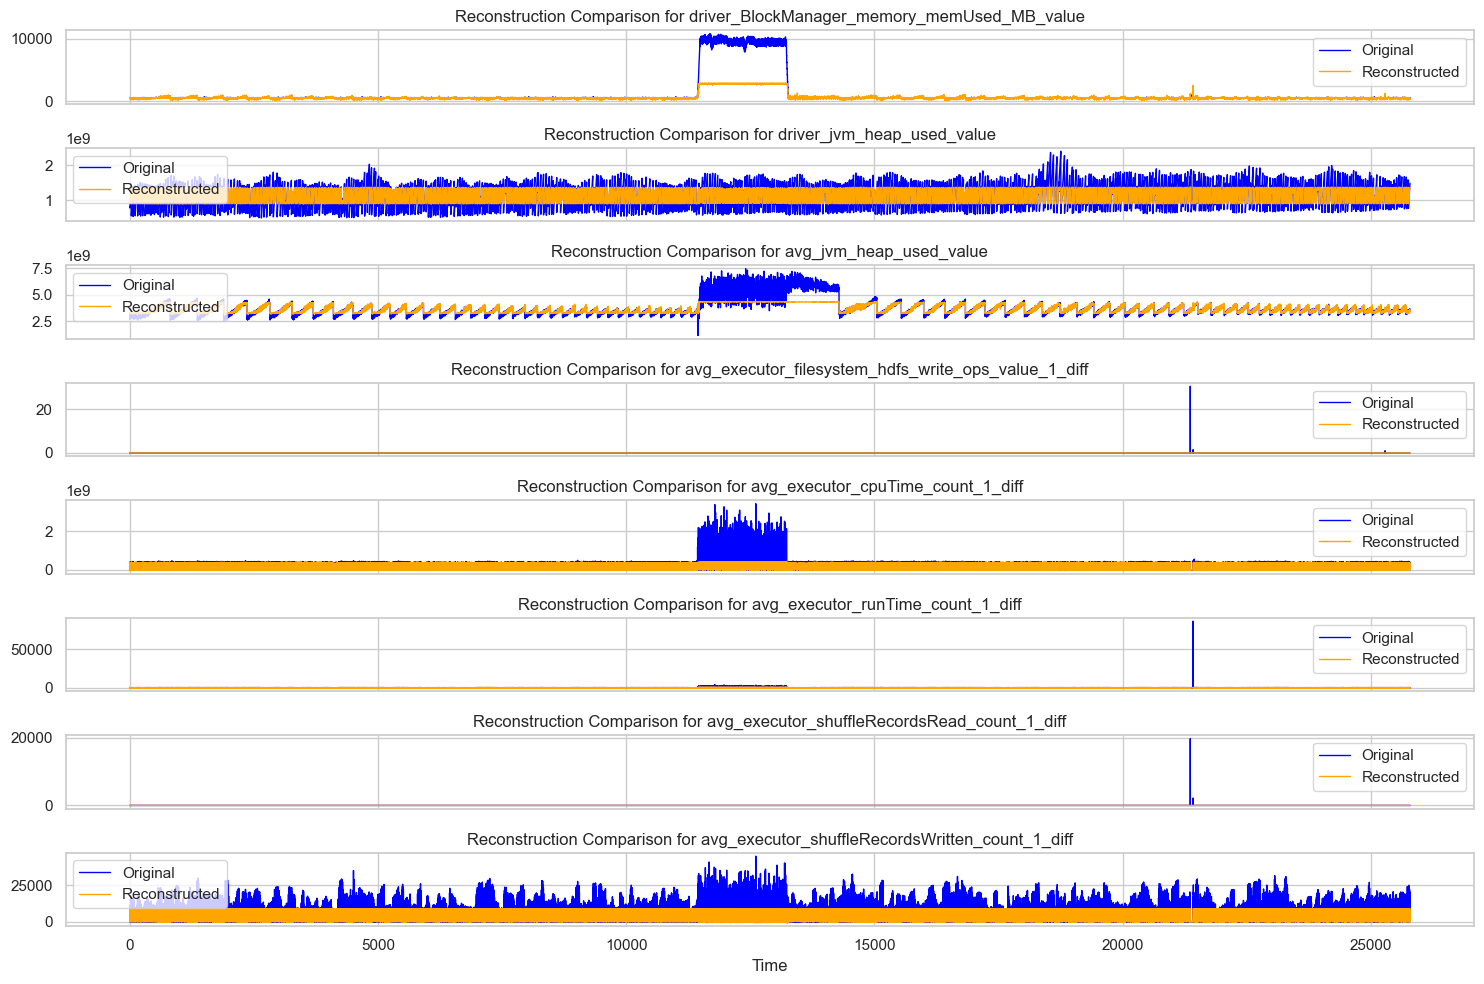

In [7]:
plot_reconstruction(df, predictions, cols,n_features)

In [8]:
def plot_anomalies(df, anomalies, cols):
    """
    Fonction pour tracer les anomalies détectées par l'autoencodeur LSTM.
    Paramètres:
        df (DataFrame): DataFrame contenant les données d'origine
        anomalies (DataFrame): DataFrame contenant les anomalies détectées
        cols (list): Liste des colonnes à tracer
    """
    # Ajouter la colonne 'time' pour référence temporelle
    anomalies['time'] = anomalies.index

    # Set the Seaborn style for better aesthetics
    sns.set(style='whitegrid')

    # Define color palette for the time series
    colors = sns.color_palette('tab10', len(cols))

    # Create a figure and axis for the plot
    plt.figure(figsize=(15, 6))
    ax = plt.gca()

    # Plot each time series with a thinner line
    for i, col in enumerate(cols):
        ax.plot(df['time'], df[col], color=colors[i], linewidth=1, label=col)

    # Highlight anomaly points with red color
    ax.scatter(anomalies['time'], df.loc[anomalies.index, cols[0]], color='red', s=50, label='Anomalies', zorder=5)

    # Set title and labels with appropriate font sizes
    ax.set_title('Time Series with Anomaly Points', fontsize=16)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Normalized Values', fontsize=14)

    # Place the legend in the upper right corner of the plot
    ax.legend(loc='upper right', frameon=True)

    # Display the plot
    plt.show()
    


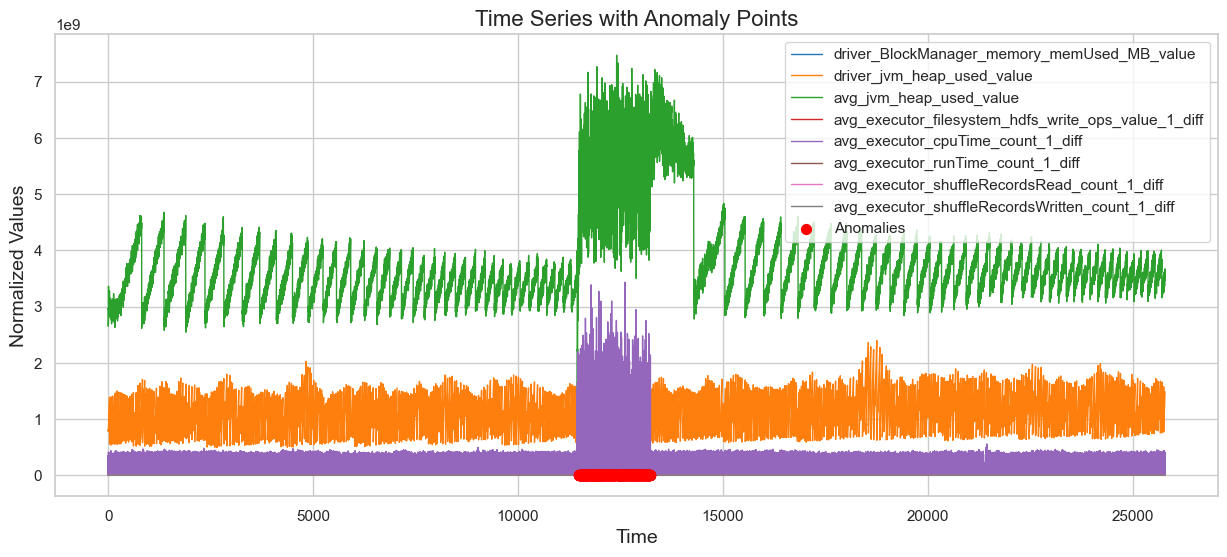

In [9]:
plot_anomalies(df, anomalies, cols)

In [10]:
def testify_continuity(anomalies):
    """
    Function to testify the continuity of anomalies.
    Parameters:
        anomalies (DataFrame): DataFrame containing the detected anomalies
    """
    # trier et ranger du plus petit au plus grand
    anomalies = anomalies.sort_values(by=['time'])
    diff = [j-i for i, j in zip(anomalies['time'][:-1], anomalies['time'][1:])]

    # print the max diff between anomalies
    max(diff)

    # plot the distribution of the time difference between anomalies
    plt.figure(figsize=(15, 6))
    plt.hist(diff, bins=20)
    plt.title('Distribution of Time Difference Between Anomalies')
    plt.xlabel('Time Difference')
    plt.ylabel('Frequency')
    plt.show()


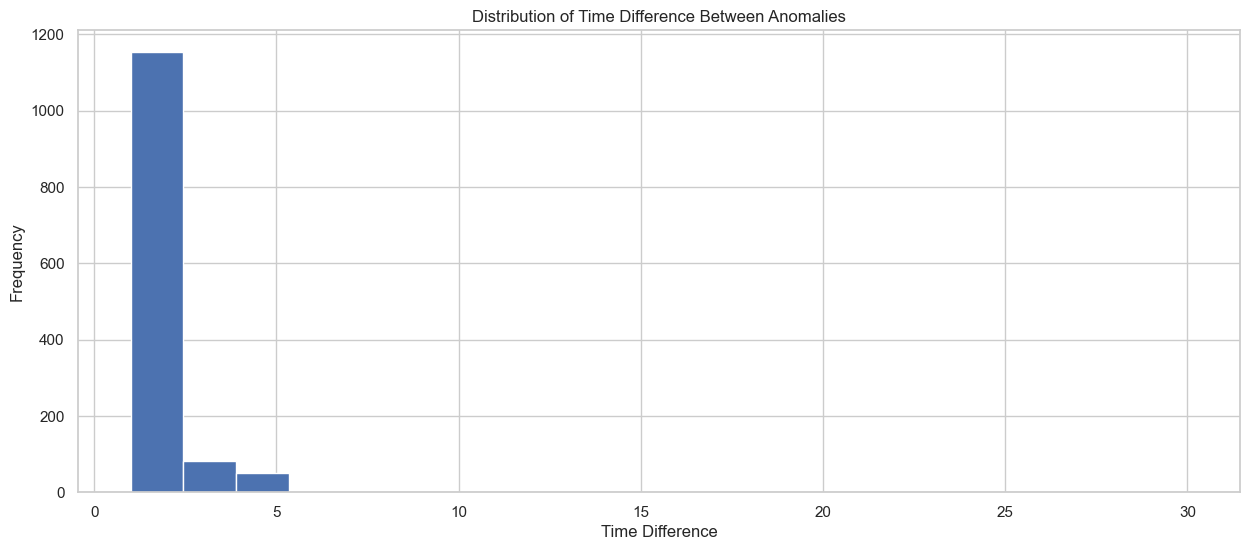

In [11]:
testify_continuity(anomalies)

In [12]:
results_list = []
traces = anomaly_df['trace_id'].unique().tolist()

# load results
results_to_fill = pd.read_csv('../data/custom_no_streaming_8/folder_2_results.csv', index_col=0)

for trace_id in traces:
    df = anomaly_df[anomaly_df['trace_id'] == trace_id].copy()
    cols = df.columns[3:]


    # Détecter les anomalies pour chaque trace_id
    anomalies, predictions = anomalies_detection(df, cols, epochs=20, n_layers=10, verbose=False)
    
    # Récupérer le min et le max du time dans anomalies pour chaque trace_id
    if not anomalies.empty:
        min = anomalies['time'].min()
        max = anomalies['time'].max()
    else:
        min = np.nan
        max = np.nan
    
    results_list.append({
        'ano_start': min,
        'ano_end': max,
        'trace_id': trace_id
    })


results_df = pd.DataFrame(results_list)


# Faire une jointure entre anomalies et results
final_results = pd.merge(results_df, results_to_fill, on='trace_id', how='left')

# Afficher les résultats finaux
print(final_results)


806/806 [==============================] - 1s 1ms/step


KeyError: 'time'

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Charger vos données
# Assurez-vous que votre fichier CSV est correctement formaté et accessible
# Exemple: df = pd.read_csv('chemin_vers_votre_fichier.csv')

# Exemple de DataFrame
df = anomaly_df[anomaly_df['trace_id'] == '1_3'].copy()

# Sélectionner les colonnes numériques pertinentes
cols = df.columns[3:]

# Normaliser les données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[cols])

# Configuration de Isolation Forest
model = IsolationForest(n_estimators=1000, max_samples='auto', contamination=float(0.0715), max_features=3)

# Entraîner le modèle
model.fit(df_scaled)

# Prédictions
df['scores'] = model.decision_function(df_scaled)
df['anomaly'] = model.predict(df_scaled)

# Identifier les anomalies (les anomalies sont marquées comme -1)
anomalies = df[df['anomaly'] == -1]
anomalies['time'] = anomalies.index

anomalies_iso = anomalies[['time','scores']].copy()
# pourcentage d'anomalies
print("Pourcentage d'anomalies :")  
print(100*len(anomalies_iso)/len(df))

plot_anomalies(df, anomalies_iso, cols)


Pourcentage d'anomalies :
7.150889983324931


C:\Users\choho\AppData\Local\Temp\ipykernel_34628\2280832822.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['time'] = anomalies.index


NameError: name 'plot_anomalies' is not defined